In [1]:
# pip install torch torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.utils as vutils
import torch.nn as nn
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from loss_functions import CombinedLoss
from discriminator_model import DiscriminatorModel
from upscaling_model import UpscalingModel
from data_sets_loaders import get_train_val_test_dataloaders
import os

%matplotlib inline

In [2]:
def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:4].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()


def train_prototype(train_dl, val_dl, num_epochs=5, learning_rate=1e-4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    discriminator_model = DiscriminatorModel(3, 8, 0.3).to(device)
    upscaling_model = UpscalingModel(3, 3, 3, 32, 10).to(device)

    upscaling_model.to(device)
    discriminator_model.to(device)
    upscaling_model.train()
    discriminator_model.train()

    torch.manual_seed(42)
    criterion = CombinedLoss(0.0, 1.0, 1.0, 0.0, 100.0, device=device)
    optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=learning_rate) 
    optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate) 
    
    iters, train_losses, val_losses = [], [], []
    n = 0
    for epoch in range(num_epochs):

        if epoch == 2:
            criterion = CombinedLoss(0.1, 1.0, 1.0, 1.0, 100.0, device=device)

        train_count    = 0
        val_count      = 0
        train_loss_sum = 0
        val_loss_sum   = 0

        num_batches = len(train_dl)
        for batch_i, (inputs_lr, targets_hr) in enumerate(train_dl):

            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)

            real_labels = torch.ones(inputs_lr.shape[0], 1).to(device)
            generated_labels = torch.zeros(inputs_lr.shape[0], 1).to(device)

            # Update Discriminator
            real_outputs = discriminator_model(targets_hr)
            discriminator_loss_real = criterion(None, real_labels, real_outputs, is_discriminator=True)

            generated_hr = upscaling_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr.detach())
            discriminator_loss_generated = criterion(None, generated_labels, generated_outputs, is_discriminator=True)

            discriminator_loss = discriminator_loss_real + discriminator_loss_generated

            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Update Generator
            generated_outputs = discriminator_model(targets_hr)
            generator_loss = criterion(generated_hr, targets_hr, generated_outputs)

            optimizer_upscale.zero_grad()
            generator_loss.backward()
            optimizer_upscale.step()

            train_loss_sum += generator_loss.item()
            train_count += 1

            if (batch_i+1) % 20 == 0:
                print(f"Batch {batch_i+1}/{num_batches}, generator loss {generator_loss.item()}, discriminator loss {discriminator_loss.item()}")

        #For Validation Set 
        with torch.no_grad():
            for inputs_lr_val, targets_hr_val in val_dl: 
                inputs_lr_val = inputs_lr_val.to(device)
                targets_hr_val = targets_hr_val.to(device)

                # Compute Loss
                generated_hr_val = upscaling_model(inputs_lr_val)
                generated_outputs = discriminator_model(targets_hr_val)
                generator_loss = criterion(generated_hr_val, targets_hr_val, generated_outputs)

                single_val_loss = generator_loss

                val_loss_sum += single_val_loss.item()
                val_count += 1

        iters.append(n)

        t_loss = train_loss_sum/train_count
        v_loss = val_loss_sum/val_count
        train_losses.append(t_loss)
        val_losses.append(v_loss)

        n += 1
        print("#"+str(n)+": training loss value = "+str(t_loss)+" validation loss value = "+str(v_loss))
        plot_imgs(inputs_lr_val)
        plot_imgs(generated_hr_val)
        plot_imgs(targets_hr_val)
        print()

        os.makedirs("prototype_models", exist_ok=True)
        model_upscale_path = f"prototype_models/model_{epoch+1}_g.pth"
        model_discrim_path = f"prototype_models/model_{epoch+1}_d.pth"
        torch.save(upscaling_model, model_upscale_path)
        torch.save(discriminator_model, model_discrim_path)

    return(iters, train_losses, val_losses)


Batch 20/160, generator loss 3.848642110824585, discriminator loss 1.007213830947876
Batch 40/160, generator loss 3.5359292030334473, discriminator loss 1.0064759254455566
Batch 60/160, generator loss 4.160724639892578, discriminator loss 1.0217454433441162
Batch 80/160, generator loss 1.6615290641784668, discriminator loss 1.2800790071487427
Batch 100/160, generator loss 2.9315176010131836, discriminator loss 1.2372503280639648
Batch 120/160, generator loss 2.546783447265625, discriminator loss 1.0082712173461914
Batch 140/160, generator loss 1.9227235317230225, discriminator loss 1.0252935886383057
Batch 160/160, generator loss 1.8812057971954346, discriminator loss 1.3811051845550537
#1: training loss value = 3.6114856623113156 validation loss value = 2.4975939273834227


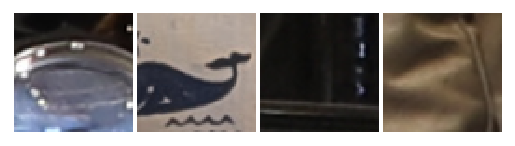

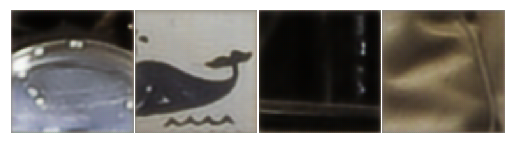

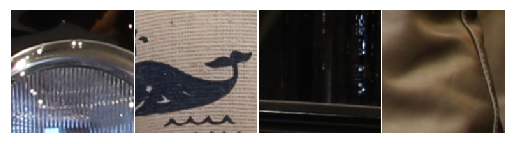


Batch 20/160, generator loss 1.519707202911377, discriminator loss 1.0628193616867065
Batch 40/160, generator loss 1.8844047784805298, discriminator loss 1.0606977939605713
Batch 60/160, generator loss 2.0273027420043945, discriminator loss 1.1310495138168335
Batch 80/160, generator loss 1.6668672561645508, discriminator loss 1.126301646232605
Batch 100/160, generator loss 1.6554564237594604, discriminator loss 1.5367016792297363
Batch 120/160, generator loss 1.9072192907333374, discriminator loss 1.137048602104187
Batch 140/160, generator loss 2.236478328704834, discriminator loss 1.0689942836761475
Batch 160/160, generator loss 1.7299792766571045, discriminator loss 1.3862934112548828
#2: training loss value = 2.4898965738713743 validation loss value = 2.1791093826293944


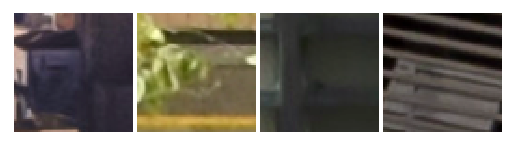

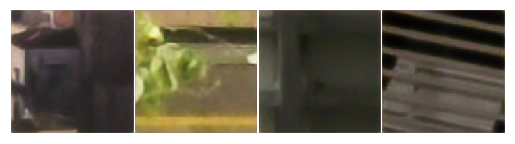

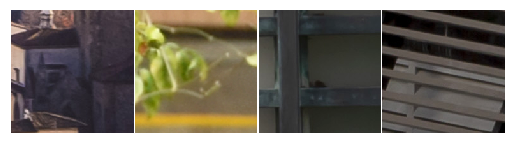


Batch 20/160, generator loss 8.99841594696045, discriminator loss 1.0064280033111572
Batch 40/160, generator loss 5.429902076721191, discriminator loss 1.0064113140106201
Batch 60/160, generator loss 3.704136610031128, discriminator loss 1.006409764289856
Batch 80/160, generator loss 3.9819869995117188, discriminator loss 1.0064090490341187
Batch 100/160, generator loss 4.797462463378906, discriminator loss 1.006408929824829
Batch 120/160, generator loss 5.1070685386657715, discriminator loss 1.0585639476776123
Batch 140/160, generator loss 9.724021911621094, discriminator loss 1.0865635871887207
Batch 160/160, generator loss 12.151230812072754, discriminator loss 1.0064090490341187
#3: training loss value = 6.531556639075279 validation loss value = 6.172144293785095


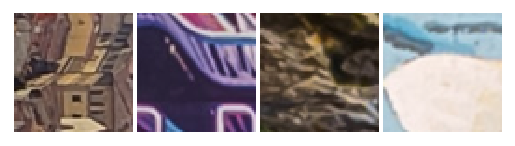

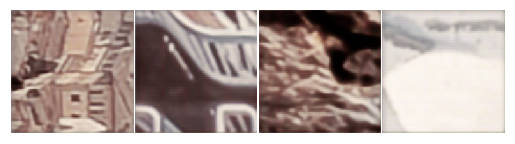

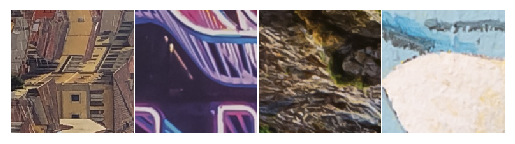


Batch 20/160, generator loss 8.858227729797363, discriminator loss 1.0240089893341064
Batch 40/160, generator loss 7.3056159019470215, discriminator loss 1.00655198097229
Batch 60/160, generator loss 4.959723472595215, discriminator loss 1.155813455581665
Batch 80/160, generator loss 6.58836030960083, discriminator loss 1.0064090490341187
Batch 100/160, generator loss 13.228425025939941, discriminator loss 1.0064167976379395
Batch 120/160, generator loss 5.217340469360352, discriminator loss 1.0064142942428589
Batch 140/160, generator loss 4.363282680511475, discriminator loss 1.0064091682434082
Batch 160/160, generator loss 5.620938301086426, discriminator loss 1.0068995952606201
#4: training loss value = 5.645628222823143 validation loss value = 4.533414468169212


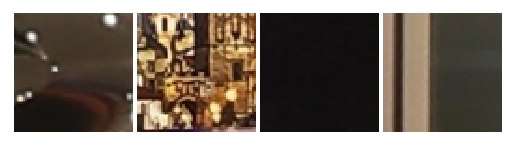

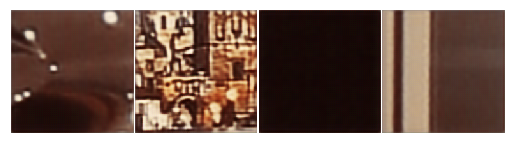

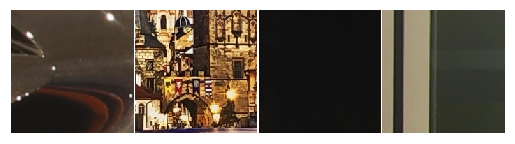


Batch 20/160, generator loss 8.389238357543945, discriminator loss 1.006805658340454
Batch 40/160, generator loss 4.921631813049316, discriminator loss 1.006408929824829
Batch 60/160, generator loss 4.988565444946289, discriminator loss 1.006411075592041
Batch 80/160, generator loss 4.388819694519043, discriminator loss 1.0405452251434326
Batch 100/160, generator loss 1.750138759613037, discriminator loss 1.008014440536499
Batch 120/160, generator loss 3.7085213661193848, discriminator loss 1.0890551805496216
Batch 140/160, generator loss 3.244605541229248, discriminator loss 1.0064090490341187
Batch 160/160, generator loss 18.210905075073242, discriminator loss 1.422734022140503
#5: training loss value = 4.958320111036301 validation loss value = 3.862946778535843


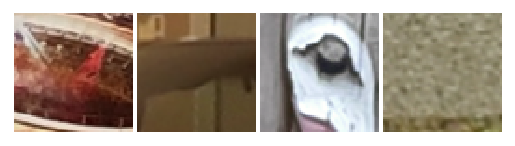

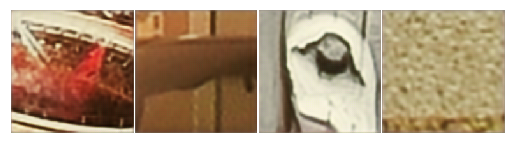

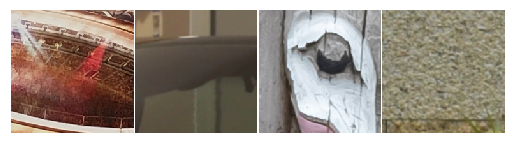


Batch 20/160, generator loss 3.765432119369507, discriminator loss 1.0497674942016602
Batch 40/160, generator loss 3.633486747741699, discriminator loss 1.0064104795455933
Batch 60/160, generator loss 2.0915958881378174, discriminator loss 1.5115830898284912
Batch 80/160, generator loss 3.375230312347412, discriminator loss 1.303547978401184
Batch 100/160, generator loss 4.307339191436768, discriminator loss 1.204036831855774
Batch 120/160, generator loss 2.692655563354492, discriminator loss 1.059422254562378
Batch 140/160, generator loss 3.364243984222412, discriminator loss 1.471284031867981
Batch 160/160, generator loss 13.461600303649902, discriminator loss 1.101356029510498
#6: training loss value = 4.9167628034949304 validation loss value = 4.990218591690064


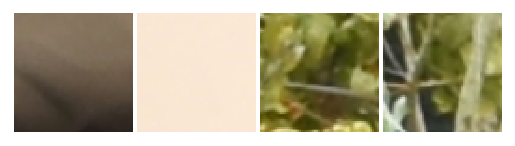

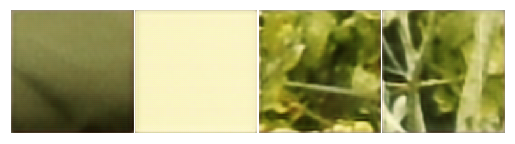

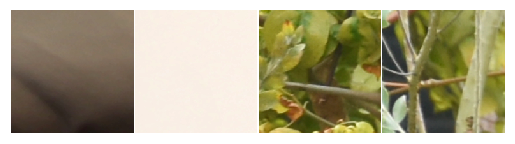


Batch 20/160, generator loss 4.207127571105957, discriminator loss 1.1024162769317627
Batch 40/160, generator loss 4.404634475708008, discriminator loss 1.00694739818573
Batch 60/160, generator loss 3.923675298690796, discriminator loss 1.0065432786941528
Batch 80/160, generator loss 2.0045716762542725, discriminator loss 1.1793675422668457
Batch 100/160, generator loss 2.828138828277588, discriminator loss 1.0064737796783447
Batch 120/160, generator loss 4.6571831703186035, discriminator loss 1.0064315795898438
Batch 140/160, generator loss 4.890157222747803, discriminator loss 1.0064101219177246
Batch 160/160, generator loss 3.7685658931732178, discriminator loss 1.007828950881958
#7: training loss value = 4.588288385421038 validation loss value = 4.550070986151695


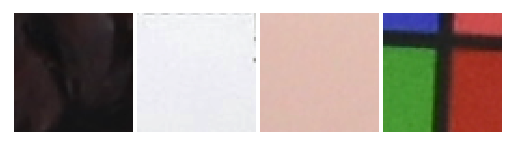

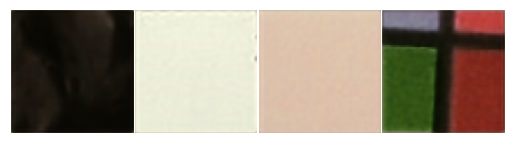

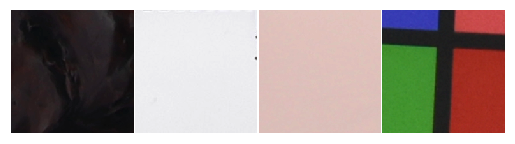


Batch 20/160, generator loss 5.625854015350342, discriminator loss 1.006408929824829
Batch 40/160, generator loss 3.7808544635772705, discriminator loss 1.006408929824829
Batch 60/160, generator loss 3.0071542263031006, discriminator loss 1.0076764822006226
Batch 80/160, generator loss 4.106203079223633, discriminator loss 1.0064257383346558
Batch 100/160, generator loss 2.9501559734344482, discriminator loss 1.3862943649291992
Batch 120/160, generator loss 3.0190086364746094, discriminator loss 1.0066282749176025
Batch 140/160, generator loss 4.044134140014648, discriminator loss 1.006410837173462
Batch 160/160, generator loss 1.5950486660003662, discriminator loss 1.007002592086792
#8: training loss value = 4.351886920630932 validation loss value = 3.8397819638252257


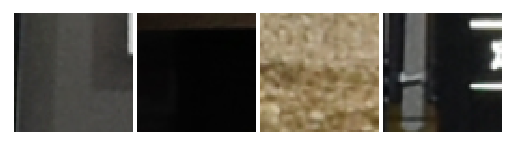

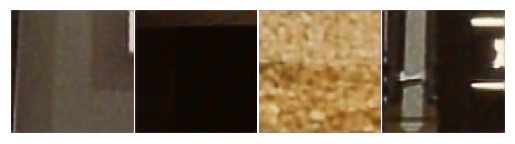

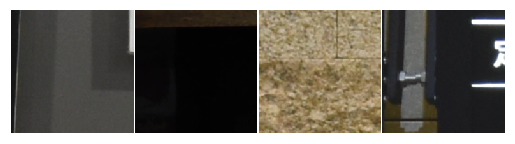


Batch 20/160, generator loss 7.297152042388916, discriminator loss 1.0064849853515625
Batch 40/160, generator loss 4.7109694480896, discriminator loss 1.0066051483154297
Batch 60/160, generator loss 2.403599977493286, discriminator loss 1.0065003633499146
Batch 80/160, generator loss 5.405177116394043, discriminator loss 1.0064181089401245
Batch 100/160, generator loss 4.8077778816223145, discriminator loss 1.0064095258712769
Batch 120/160, generator loss 3.135899543762207, discriminator loss 1.006412148475647
Batch 140/160, generator loss 3.105020761489868, discriminator loss 1.006408929824829
Batch 160/160, generator loss 2.9765257835388184, discriminator loss 1.006408929824829
#9: training loss value = 3.8512927539646626 validation loss value = 3.596087175607681


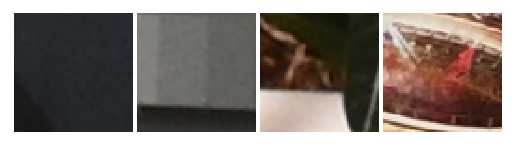

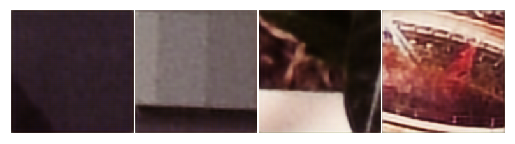

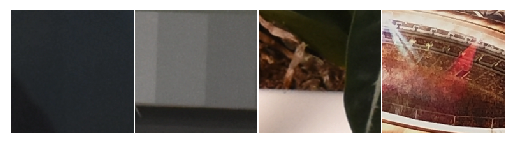


Batch 20/160, generator loss 3.1057116985321045, discriminator loss 1.0064105987548828
Batch 40/160, generator loss 4.827976703643799, discriminator loss 1.0064213275909424
Batch 60/160, generator loss 6.4296417236328125, discriminator loss 1.006408929824829
Batch 80/160, generator loss 2.767622709274292, discriminator loss 1.006408929824829
Batch 100/160, generator loss 4.046510696411133, discriminator loss 1.006408929824829
Batch 120/160, generator loss 2.7152514457702637, discriminator loss 1.006408929824829
Batch 140/160, generator loss 3.0950028896331787, discriminator loss 1.006408929824829
Batch 160/160, generator loss 5.367175102233887, discriminator loss 1.006408929824829
#10: training loss value = 3.85611924007535 validation loss value = 3.2523960560560226


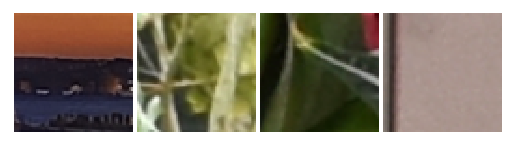

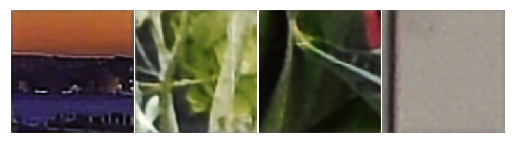

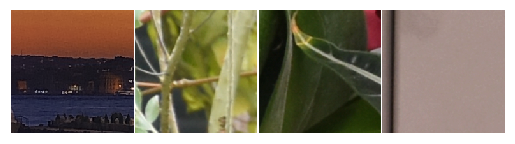


Batch 20/160, generator loss 4.347315788269043, discriminator loss 1.006408929824829
Batch 40/160, generator loss 3.397726058959961, discriminator loss 1.006408929824829
Batch 60/160, generator loss 1.7078030109405518, discriminator loss 1.006413459777832
Batch 80/160, generator loss 2.5553293228149414, discriminator loss 1.006408929824829
Batch 100/160, generator loss 2.2359795570373535, discriminator loss 1.006408929824829
Batch 120/160, generator loss 2.042198896408081, discriminator loss 1.006408929824829
Batch 140/160, generator loss 2.1027910709381104, discriminator loss 1.0064094066619873
Batch 160/160, generator loss 4.483584403991699, discriminator loss 1.006408929824829
#11: training loss value = 3.762817703932524 validation loss value = 3.3828211963176726


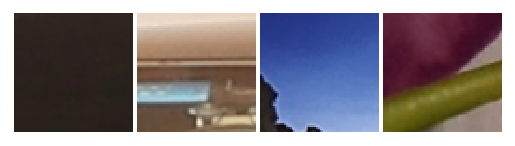

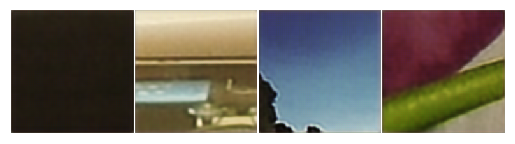

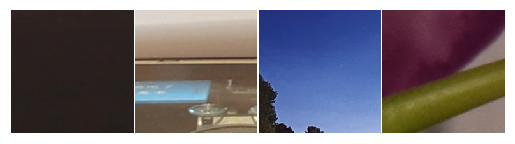


Batch 20/160, generator loss 3.6472723484039307, discriminator loss 1.0064185857772827
Batch 40/160, generator loss 4.451019287109375, discriminator loss 1.0160895586013794
Batch 60/160, generator loss 6.474209785461426, discriminator loss 1.0064247846603394
Batch 80/160, generator loss 2.7139172554016113, discriminator loss 1.006408929824829
Batch 100/160, generator loss 3.592585325241089, discriminator loss 1.0064096450805664
Batch 120/160, generator loss 2.0623509883880615, discriminator loss 1.0064270496368408
Batch 140/160, generator loss 5.730831146240234, discriminator loss 1.006408929824829
Batch 160/160, generator loss 2.5557773113250732, discriminator loss 1.006408929824829
#12: training loss value = 3.689201405644417 validation loss value = 3.0245980620384216


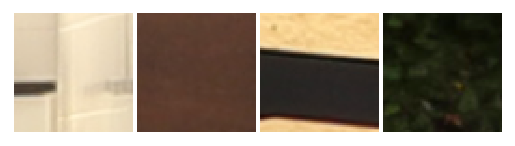

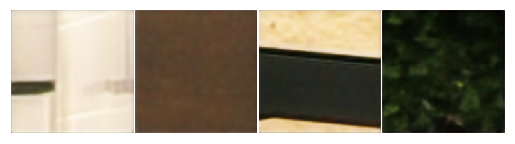

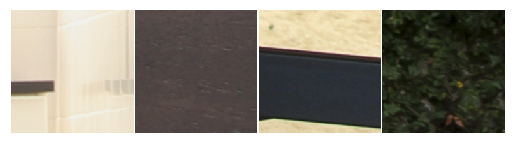


Batch 20/160, generator loss 3.7657673358917236, discriminator loss 1.006679654121399
Batch 40/160, generator loss 2.5887057781219482, discriminator loss 1.006408929824829
Batch 60/160, generator loss 3.6463875770568848, discriminator loss 1.006408929824829
Batch 80/160, generator loss 2.6352860927581787, discriminator loss 1.006408929824829
Batch 100/160, generator loss 5.340891361236572, discriminator loss 1.006408929824829
Batch 120/160, generator loss 3.1931471824645996, discriminator loss 1.006408929824829
Batch 140/160, generator loss 3.223942995071411, discriminator loss 1.0067620277404785
Batch 160/160, generator loss 4.967884540557861, discriminator loss 1.006408929824829
#13: training loss value = 3.872722951322794 validation loss value = 3.717402106523514


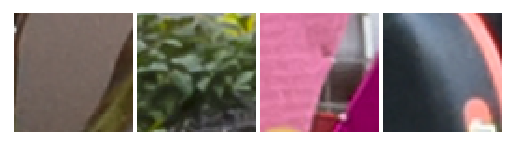

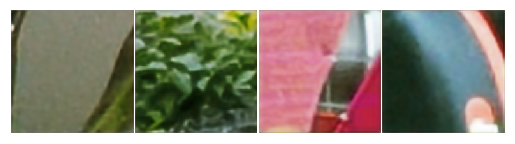

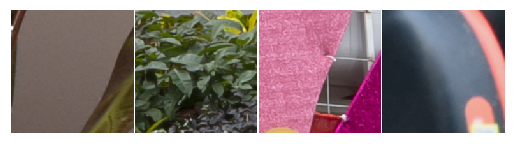


Batch 20/160, generator loss 6.7488484382629395, discriminator loss 1.0064098834991455
Batch 40/160, generator loss 3.8564183712005615, discriminator loss 1.006408929824829
Batch 60/160, generator loss 1.811876893043518, discriminator loss 1.006408929824829
Batch 80/160, generator loss 2.905959129333496, discriminator loss 1.006408929824829
Batch 100/160, generator loss 2.6232213973999023, discriminator loss 1.0511925220489502
Batch 120/160, generator loss 4.089470863342285, discriminator loss 1.006408929824829
Batch 140/160, generator loss 1.4438719749450684, discriminator loss 1.006408929824829
Batch 160/160, generator loss 7.3034563064575195, discriminator loss 1.0089459419250488
#14: training loss value = 3.7636948838829993 validation loss value = 3.803850609064102


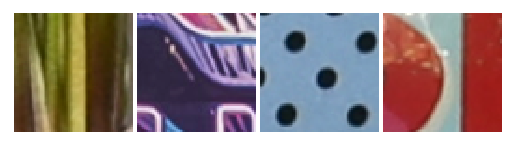

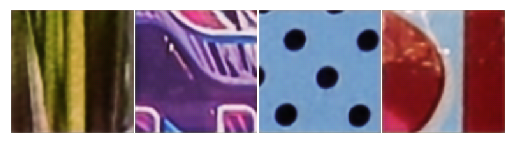

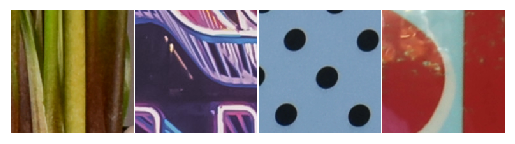


Batch 20/160, generator loss 4.118560314178467, discriminator loss 1.006408929824829
Batch 40/160, generator loss 4.454400539398193, discriminator loss 1.006408929824829
Batch 60/160, generator loss 2.615962505340576, discriminator loss 1.0064115524291992
Batch 80/160, generator loss 5.858233451843262, discriminator loss 1.006408929824829
Batch 100/160, generator loss 4.214066982269287, discriminator loss 1.0064805746078491
Batch 120/160, generator loss 3.199293613433838, discriminator loss 1.626523494720459
Batch 140/160, generator loss 2.476884603500366, discriminator loss 1.626523494720459
Batch 160/160, generator loss 6.4150614738464355, discriminator loss 1.626523494720459
#15: training loss value = 3.825707957148552 validation loss value = 3.920086270570755


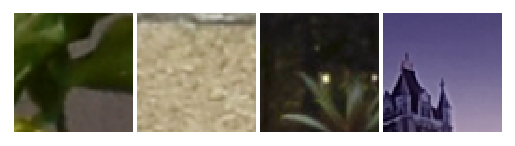

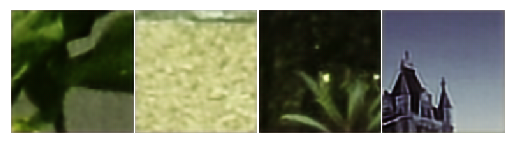

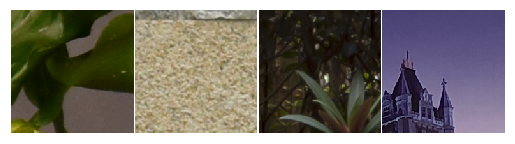


Batch 20/160, generator loss 2.454857349395752, discriminator loss 1.626523494720459
Batch 40/160, generator loss 3.380326271057129, discriminator loss 1.626523494720459
Batch 60/160, generator loss 2.1426026821136475, discriminator loss 1.626523494720459
Batch 80/160, generator loss 2.817234754562378, discriminator loss 1.626523494720459
Batch 100/160, generator loss 5.044645309448242, discriminator loss 1.626523494720459
Batch 120/160, generator loss 3.284756660461426, discriminator loss 1.626523494720459
Batch 140/160, generator loss 4.072321891784668, discriminator loss 1.626523494720459
Batch 160/160, generator loss 1.6335294246673584, discriminator loss 1.626523494720459
#16: training loss value = 3.7942196279764175 validation loss value = 3.102005723118782


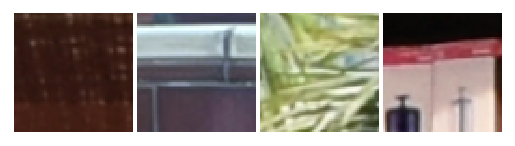

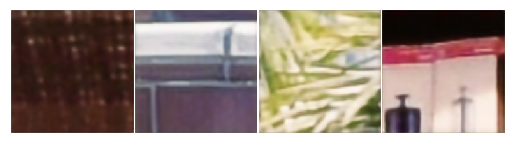

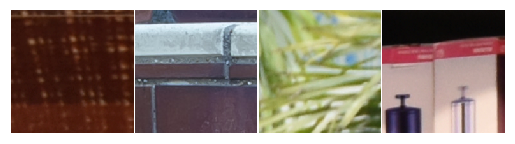


Batch 20/160, generator loss 7.212409496307373, discriminator loss 1.626523494720459
Batch 40/160, generator loss 3.4681782722473145, discriminator loss 1.626523494720459
Batch 60/160, generator loss 3.2690212726593018, discriminator loss 1.626523494720459
Batch 80/160, generator loss 5.772031307220459, discriminator loss 1.626523494720459
Batch 100/160, generator loss 5.407684803009033, discriminator loss 1.626523494720459
Batch 120/160, generator loss 2.7510807514190674, discriminator loss 1.626523494720459
Batch 140/160, generator loss 2.640462875366211, discriminator loss 1.626523494720459
Batch 160/160, generator loss 3.2037739753723145, discriminator loss 1.626523494720459
#17: training loss value = 3.8511539131402968 validation loss value = 3.2625572085380554


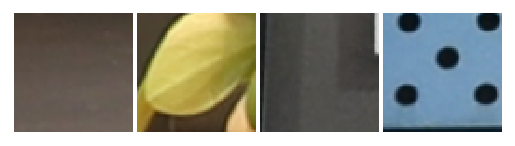

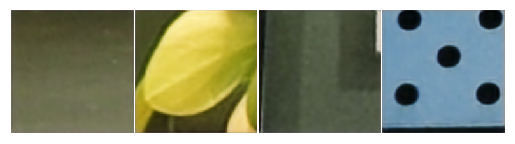

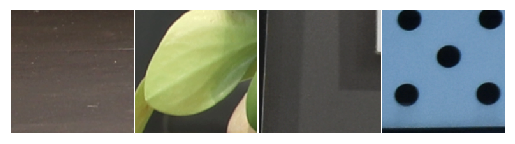


Batch 20/160, generator loss 3.8110506534576416, discriminator loss 1.626523494720459
Batch 40/160, generator loss 2.0102226734161377, discriminator loss 1.626523494720459
Batch 60/160, generator loss 3.4734301567077637, discriminator loss 1.626523494720459
Batch 80/160, generator loss 3.04636549949646, discriminator loss 1.626523494720459
Batch 100/160, generator loss 3.6070950031280518, discriminator loss 1.626523494720459
Batch 120/160, generator loss 3.6797943115234375, discriminator loss 1.626523494720459
Batch 140/160, generator loss 2.845257520675659, discriminator loss 1.626523494720459
Batch 160/160, generator loss 7.333558082580566, discriminator loss 1.626523494720459
#18: training loss value = 3.7325782522559168 validation loss value = 4.048897641897201


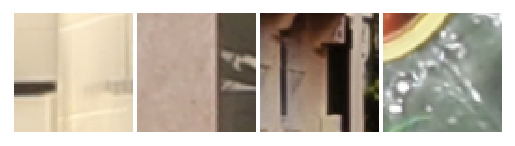

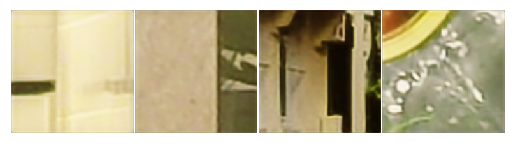

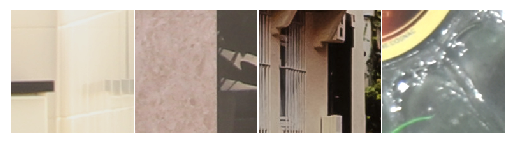


Batch 20/160, generator loss 2.1198697090148926, discriminator loss 1.626523494720459
Batch 40/160, generator loss 3.9717748165130615, discriminator loss 1.626523494720459
Batch 60/160, generator loss 2.5928056240081787, discriminator loss 1.626523494720459
Batch 80/160, generator loss 4.579559326171875, discriminator loss 1.626523494720459
Batch 100/160, generator loss 2.166351556777954, discriminator loss 1.626523494720459
Batch 120/160, generator loss 2.996145486831665, discriminator loss 1.626523494720459
Batch 140/160, generator loss 2.7624313831329346, discriminator loss 1.626523494720459
Batch 160/160, generator loss 5.825970649719238, discriminator loss 1.626523494720459
#19: training loss value = 3.721130181103945 validation loss value = 3.025974002480507


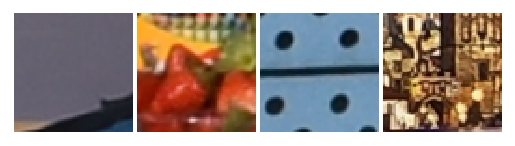

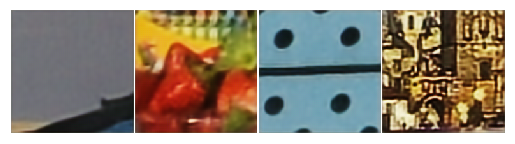

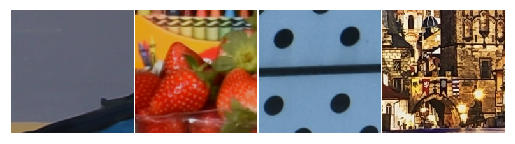


Batch 20/160, generator loss 2.910965919494629, discriminator loss 1.626523494720459
Batch 40/160, generator loss 5.20720100402832, discriminator loss 1.626523494720459
Batch 60/160, generator loss 5.006211757659912, discriminator loss 1.626523494720459
Batch 80/160, generator loss 2.6371898651123047, discriminator loss 1.626523494720459
Batch 100/160, generator loss 1.5066702365875244, discriminator loss 1.626523494720459
Batch 120/160, generator loss 4.83333683013916, discriminator loss 1.626523494720459
Batch 140/160, generator loss 3.0743181705474854, discriminator loss 1.626523494720459
Batch 160/160, generator loss 2.9497480392456055, discriminator loss 1.626523494720459
#20: training loss value = 3.6528686113655566 validation loss value = 3.32132006585598


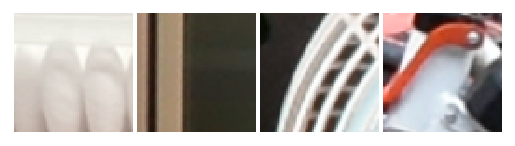

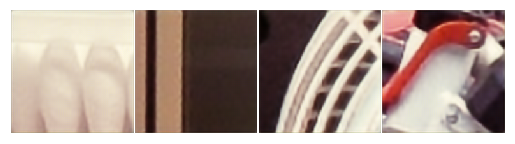

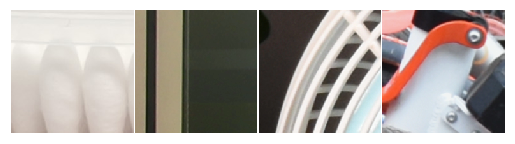

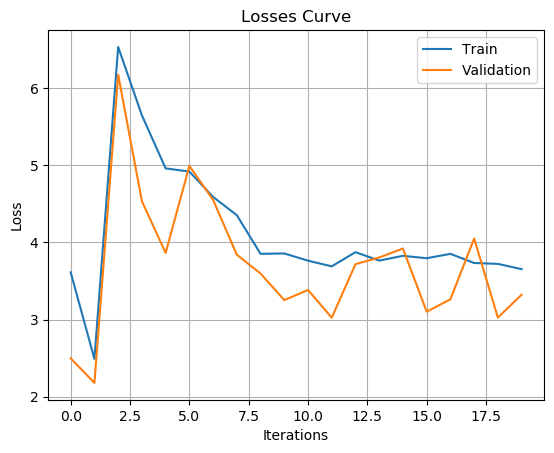

In [3]:
cropped_dir = "./cropped_images"
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

iters, train_losses, val_losses = train_prototype(train_dl, val_dl, num_epochs=20, learning_rate=0.0005)

plt.title("Losses Curve")
plt.plot(iters, train_losses, label="Train")
plt.plot(iters, val_losses, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()